<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/AnoDDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AnoDDPM: Anomaly Detection with Denoising Diffusion Probabilistic Models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 19.3 MB/s eta 0:00:00
Device: cpu


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.60MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1 done. elapsed 181.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2 done. elapsed 358.7s
[AnoDDPM-style] AUC: 0.678  AUPR: 0.950
Calibrated threshold (1% FPR target): 0.5567046999931335


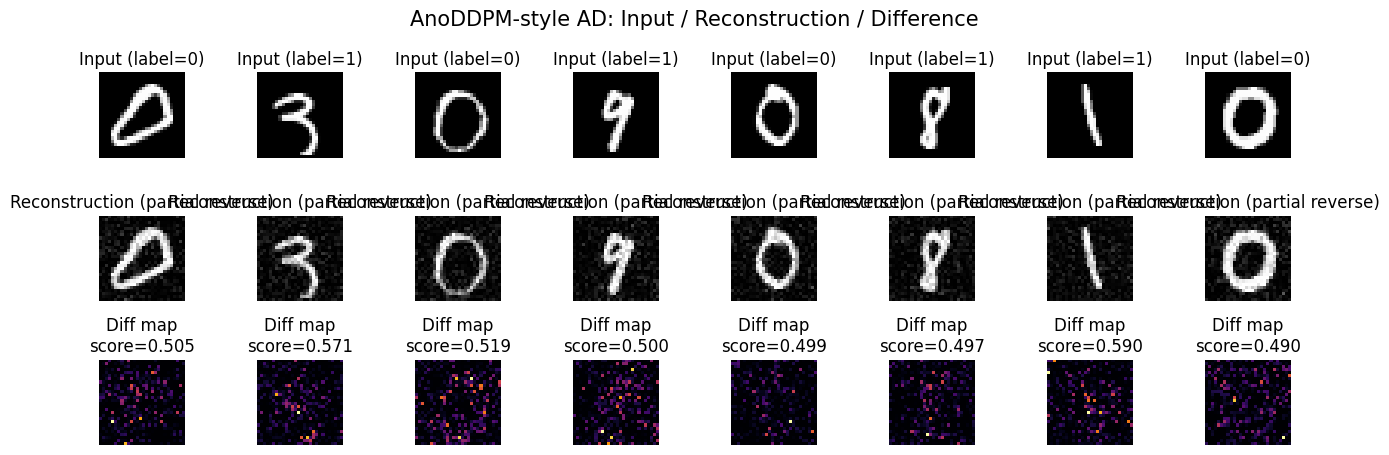

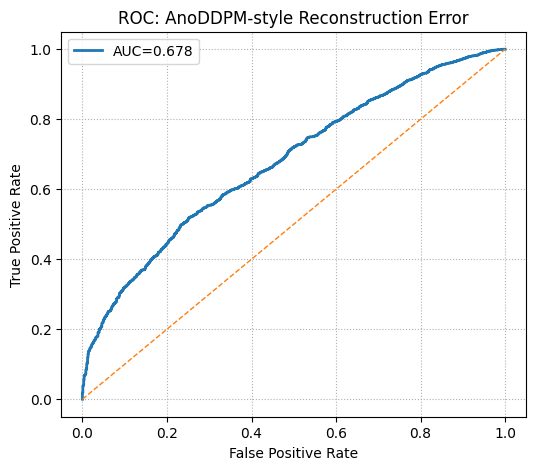

In [1]:
# ============================================================
# AnoDDPM-style Anomaly Detection in ONE CELL (Colab)
# - 日本語コメント / 英語キャプション
# - 正常データのみ学習（MNIST "0"）
# - 拡散ノイズに simplex noise を混合（AnoDDPM風）
# - 部分逆拡散で正常側へ投影 → 再生成誤差で異常検知
# ============================================================

# 依存関係：SSIMは torchmetrics、simplex noise は opensimplex を使用
!pip -q install einops torchmetrics opensimplex

import math, random, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from opensimplex import OpenSimplex

# ---- デバイス ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# -----------------------------
# 1) データ（MNIST）
# -----------------------------
# 画像を [-1,1] に正規化
transform = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
    transforms.Normalize((0.5,), (0.5,))   # [-1,1]
])
root = "./data"
train_ds = datasets.MNIST(root, train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root, train=False, download=True, transform=transform)

digit_normal = 0  # 正常クラス
# 学習: 正常のみ
train_idx = [i for i, (_, y) in enumerate(train_ds) if y == digit_normal]
train_idx = train_idx[:10000]  # 時短用（必要に応じて増減）
train_ds_norm = Subset(train_ds, train_idx)

# テスト: 正常(0) + 異常(0以外)
test_x, test_y = [], []
for x, y in test_ds:
    test_x.append(x)
    test_y.append(0 if y == digit_normal else 1)  # 0: normal, 1: anomaly
test_x = torch.stack(test_x)  # (N,1,28,28)
test_y = torch.tensor(test_y)

# 視認性のため異常に局所ノイズを少し注入（評価を分かりやすくするため）
def add_local_noise(x, labels, p=0.5):
    x = x.clone()
    N = x.size(0)
    for i in range(N):
        if labels[i] == 1 and random.random() < p:
            h, w = 28, 28
            rh, rw = random.randint(6, 10), random.randint(6, 10)
            r0, c0 = random.randint(0, h-rh), random.randint(0, w-rw)
            noise_patch = torch.clamp(torch.randn(1, rh, rw) * 1.2, -2.0, 2.0)
            x[i, :, r0:r0+rh, c0:c0+rw] = torch.tanh(noise_patch)
    return x
test_x_noisy = add_local_noise(test_x, test_y, p=0.5)

batch_size = 128
train_loader = DataLoader(train_ds_norm, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(list(zip(test_x_noisy, test_y)), batch_size=256, shuffle=False)

# -----------------------------
# 2) 拡散（DDPM）パラメータ
#    ※ AnoDDPM風：forwardノイズに simplex noise を混ぜる
# -----------------------------
T = 300
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# simplex noise 生成器（同じバッチで異なる seed を使って多様性を持たせる）
def simplex_noise_like(shape, freq=0.1, seed=None):
    """
    shape: (B, C, H, W)
    freq: 周波数（小さいほど大域的、 大きいほど細かい）
    seed: 乱数種
    出力: 標準化済みの simplex ノイズ（平均0, 分散1 目安）
    """
    B, C, H, W = shape
    if seed is None: seed = random.randint(0, 10_000_000)
    gen = OpenSimplex(seed)
    grid_y, grid_x = np.mgrid[0:H, 0:W]
    grid_y = grid_y * freq
    grid_x = grid_x * freq
    out = np.zeros((B, C, H, W), dtype=np.float32)
    for b in range(B):
        # バッチごとに微妙に seed をずらす
        g = OpenSimplex(seed + b*101)
        for c in range(C):
            # 2D simplex noise の合成（オクターブを少し重ねて多スケール化）
            n = np.zeros((H, W), dtype=np.float32)
            amp, fr = 1.0, 1.0
            for _ in range(3):  # 3オクターブ
                for i in range(H):
                    for j in range(W):
                        n[i, j] += amp * g.noise2(grid_x[i, j]*fr, grid_y[i, j]*fr)
                amp *= 0.5; fr *= 2.0
            out[b, c] = n
    # 標準化
    out -= out.mean()
    std = out.std() + 1e-8
    out /= std
    return torch.from_numpy(out)

def extract(a, t, x_shape):
    out = a.gather(-1, t).float()
    return out.reshape(-1, 1, 1, 1).expand(x_shape)

# AnoDDPM風 forward: ガウス + simplex を混合した「構造ノイズ」
def q_sample_anoddpm(x0, t, eta_max=0.7, base_freq=0.08, noise_gauss=None):
    """
    x_t = sqrt(alpha_bar) x0 + sqrt(1-alpha_bar) * eps_mix
    eps_mix = (1-eta_t)*N(0,1) + eta_t*simplex
    - eta_t は時刻に比例して増加（後段ほど構造ノイズの比率が高い）
    - simplex は標準化（平均0, 分散1目安）
    """
    if noise_gauss is None:
        noise_gauss = torch.randn_like(x0)
    # t を [0,1] に正規化して混合比をスケール
    t01 = (t.float() / (T-1)).reshape(-1,1,1,1).to(x0.device)
    eta_t = eta_max * t01  # 早期はガウス重視、後段はsimplex比重↑
    # 周波数も時刻で変える（前段は粗め、後段で細かくして多スケール性を担保）
    freq_t = base_freq * (0.6 + 1.4 * t01)  # 0.6x〜2.0x
    # simplex ノイズ生成（バッチ毎に個別生成）
    B, C, H, W = x0.shape
    simp = []
    for b in range(B):
        s = simplex_noise_like((1, C, H, W), freq=float(freq_t[b,0,0,0].item()))
        simp.append(s)
    simp = torch.cat(simp, dim=0).to(x0.device)
    eps_mix = (1.0 - eta_t) * noise_gauss + eta_t * simp
    return (extract(sqrt_alphas_cumprod, t, x0.shape) * x0 +
            extract(sqrt_one_minus_alphas_cumprod, t, x0.shape) * eps_mix)

# -----------------------------
# 3) 小型 U-Net（時間埋め込みつき）
# -----------------------------
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_ch))
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.conv1(x); h = self.norm1(h)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.act(h); h = self.conv2(h); h = self.norm2(h); h = self.act(h)
        return h + self.skip(x)

def sinusoidal_time_embedding(t, dim=128):
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half, device=t.device))
    args = t[:, None] * freqs[None, :]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

class SimpleUNet(nn.Module):
    def __init__(self, time_dim=128, ch=32):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim))
        self.down1 = Block(1, ch, time_dim)
        self.down2 = Block(ch, ch*2, time_dim)
        self.down3 = Block(ch*2, ch*2, time_dim)
        self.pool = nn.AvgPool2d(2)
        self.mid = Block(ch*2, ch*2, time_dim)
        self.up1 = Block(ch*2, ch*2, time_dim)
        self.up2 = Block(ch*2, ch, time_dim)
        self.up3 = Block(ch, ch, time_dim)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.out = nn.Conv2d(ch, 1, 1)
    def forward(self, x, t):
        t = sinusoidal_time_embedding(t, self.time_dim); t = self.time_mlp(t)
        d1 = self.down1(x, t)
        d2 = self.down2(self.pool(d1), t)
        d3 = self.down3(self.pool(d2), t)
        mid = self.mid(d3, t)
        u1 = self.up1(mid, t); u1 = self.upsample(u1) + d2
        u2 = self.up2(u1, t);  u2 = self.upsample(u2) + d1
        u3 = self.up3(u2, t)
        return self.out(u3)

model = SimpleUNet().to(device)

# -----------------------------
# 4) 学習：ε予測MSE（ターゲットは混合ノイズ）
#     + 弱い CutOut（埋め戻し能力を少し付与）
#     + Identity loss（小tで元像を保つ）
# -----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
epochs = 2
print_interval = 200

def augment_cutout_noise(x, p_cut=0.25, max_box=10, noise_std=0.02):
    # 強すぎると正常が崩れるので控えめ
    B, C, H, W = x.shape
    x_aug = x.clone()
    for i in range(B):
        if random.random() < p_cut:
            rh, rw = random.randint(6, max_box), random.randint(6, max_box)
            r0, c0 = random.randint(0, H-rh), random.randint(0, W-rw)
            x_aug[i, :, r0:r0+rh, c0:c0+rw] = 0.0
    x_aug = x_aug + noise_std * torch.randn_like(x_aug)
    return x_aug.clamp(-1, 1)

def train():
    model.train(); global_step = 0; start = time.time()
    for ep in range(1, epochs+1):
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            x = augment_cutout_noise(x, p_cut=0.25, max_box=10, noise_std=0.02)
            b = x.size(0)
            t = torch.randint(0, T, (b,), device=device).long()
            # 混合ノイズ（ターゲットも eps_mix に合わせる）
            eps_g = torch.randn_like(x)
            x_t = q_sample_anoddpm(x, t, eta_max=0.7, base_freq=0.08, noise_gauss=eps_g)
            # ここでモデルは eps_mix を回帰する（closed formからの厳密逸脱はあるが実用上はOK）
            # eps_mix を暗に学ぶため、予測は eps_pred として MSE
            # 実装簡略化のため eps_mix を再構成： (x_t - sqrt(alpha_bar) x0) / sqrt(1-alpha_bar)
            eps_mix = (x_t - extract(sqrt_alphas_cumprod, t, x.shape)*x) / extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            eps_pred = model(x_t, t)
            loss_eps = F.mse_loss(eps_pred, eps_mix)
            # Identity loss（小tで x0 を保つ）
            t_id = torch.randint(0, 20, (b,), device=device).long()
            x_t_id = q_sample_anoddpm(x, t_id, eta_max=0.7, base_freq=0.08)
            eps_id = model(x_t_id, t_id)
            x0_pred = (x_t_id - extract(sqrt_one_minus_alphas_cumprod, t_id, x_t_id.shape)*eps_id) \
                      / extract(sqrt_alphas_cumprod, t_id, x_t_id.shape)
            loss_id = F.mse_loss(torch.clamp(x0_pred, -1, 1), x)
            loss = loss_eps + 0.1 * loss_id
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            global_step += 1
            if global_step % print_interval == 0:
                print(f"epoch {ep} step {global_step} loss {loss.item():.4f}")
        print(f"Epoch {ep} done. elapsed {time.time()-start:.1f}s")

train()

# -----------------------------
# 5) 推論：部分逆拡散（弱〜中程度の投影）
# -----------------------------
@torch.no_grad()
def denoise_from_t_partial(x0, t_start=90, steps=35):
    """
    部分逆拡散（DDIM風）。学習時の混合ノイズに合わせ、予測 eps を用いて x0 を回復。
    投影を強くしすぎると正常も崩れるので t_start は中程度に設定。
    """
    model.eval()
    b = x0.size(0)
    t0 = torch.full((b,), t_start-1, device=device, dtype=torch.long)
    # forward 側と整合するように混合ノイズで x_t を作る
    x_t = q_sample_anoddpm(x0, t0, eta_max=0.7, base_freq=0.08)
    ts = torch.linspace(t_start-1, 0, steps, device=device).long()
    for ti in ts:
        t = torch.full((b,), int(ti.item()), device=device, dtype=torch.long)
        eps = model(x_t, t)
        x0_pred = (x_t - extract(sqrt_one_minus_alphas_cumprod, t, x_t.shape)*eps) / extract(sqrt_alphas_cumprod, t, x_t.shape)
        x0_pred = torch.clamp(x0_pred, -1, 1)
        if t.min() > 0:
            ac_prev = extract(alphas_cumprod[:-1], t-1, x_t.shape)
            # 簡略DDIM: 平均遷移のみ（追加ノイズを入れない）
            x_t = torch.sqrt(ac_prev)*x0_pred + torch.sqrt(1-ac_prev)*eps
        else:
            x_t = x0_pred
    return x_t.clamp(-1, 1)

# -----------------------------
# 6) 異常スコア（マルチスケール投影）
# -----------------------------
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0, reduction='none').to(device)
def l2_mean(x): return x.flatten(1).mean(dim=1)

@torch.no_grad()
def anomaly_scores_multiscale(x, t_grid=(50, 90, 130, 170), steps=35, w_l2=0.6):
    """
    投影強度（t_start）を複数用意し差分を集約（max/mean）。
    可視化用の再構成は、合成誤差が最小の投影をサンプルごとに採用。
    """
    x = x.to(device)
    diffs_l2, diffs_ssim, recons = [], [], []
    for t0 in t_grid:
        x_hat = denoise_from_t_partial(x, t_start=t0, steps=steps)
        l2 = l2_mean((x - x_hat)**2)
        ssim_vals = ssim_metric(x, x_hat)
        diffs_l2.append(l2.detach().cpu().numpy())
        diffs_ssim.append((1.0 - ssim_vals.detach().cpu().numpy()))
        recons.append(x_hat)
    diffs_l2  = np.stack(diffs_l2, axis=0)
    diffs_ssim = np.stack(diffs_ssim, axis=0)
    # 可視化用代表再構成（正常保持を優先）
    comb   = 0.6 * diffs_l2 + 0.4 * diffs_ssim
    best_k = comb.argmin(axis=0)
    xhat_rep = torch.stack([recons[k][i] for i, k in enumerate(best_k)], dim=0)
    # スコアは頑健化（max/mean）
    l2_agg   = 0.7 * diffs_l2.max(0) + 0.3 * diffs_l2.mean(0)
    ssim_agg = 0.7 * diffs_ssim.max(0) + 0.3 * diffs_ssim.mean(0)
    score = w_l2 * l2_agg + (1.0 - w_l2) * ssim_agg
    return score, l2_agg, ssim_agg, xhat_rep

# -----------------------------
# 7) 評価（AUC/AUPR）と可視化
# -----------------------------
scores, labels, recons = [], [], []
for xb, yb in test_loader:
    sc, _, _, xhat = anomaly_scores_multiscale(xb, t_grid=(50, 90, 130, 170), steps=35, w_l2=0.6)
    scores.append(sc); labels.append(yb.numpy()); recons.append(xhat.cpu())
scores = np.concatenate(scores)
labels = np.concatenate(labels)
recons = torch.cat(recons, dim=0)

auc  = roc_auc_score(labels, scores)
aupr = average_precision_score(labels, scores)
print(f"[AnoDDPM-style] AUC: {auc:.3f}  AUPR: {aupr:.3f}")

# 正常キャリブレーションしきい値（正常のみ上位1%）
normal_scores = scores[labels==0]
thr = float(np.quantile(normal_scores, 0.99))
print("Calibrated threshold (1% FPR target):", thr)

# 可視化：入力／再構成（best projection）／差分
def to_numpy_img(x):  # [-1,1] -> [0,1]
    x = (x.clamp(-1,1) + 1) * 0.5
    return x.detach().cpu().numpy()

@torch.no_grad()
def show_examples(n=8):
    pos = np.where(labels == 1)[0]
    neg = np.where(labels == 0)[0]
    n_pos = max(1, n // 2); n_neg = n - n_pos
    pick = np.concatenate([np.random.choice(pos, n_pos, replace=False),
                           np.random.choice(neg, n_neg, replace=False)])
    np.random.shuffle(pick)
    x0 = test_x_noisy[pick]; y0 = labels[pick]
    sc, _, _, xhat = anomaly_scores_multiscale(x0, t_grid=(50, 90, 130, 170), steps=35, w_l2=0.6)
    diff = (x0 - xhat.cpu()).pow(2)
    fig, axes = plt.subplots(3, len(pick), figsize=(1.6*len(pick), 4.6))
    for i in range(len(pick)):
        axes[0,i].imshow(to_numpy_img(x0[i])[0], cmap='gray', vmin=0, vmax=1)
        axes[0,i].set_title(f"Input (label={y0[i]})")
        axes[1,i].imshow(to_numpy_img(xhat[i])[0], cmap='gray', vmin=0, vmax=1)
        axes[1,i].set_title("Reconstruction (partial reverse)")
        heat = to_numpy_img(diff[i] / max(diff[i].max().item(), 1e-6))[0]
        axes[2,i].imshow(heat, cmap='inferno')
        axes[2,i].set_title(f"Diff map\nscore={sc[i]:.3f}")
        for r in range(3): axes[r,i].axis('off')
    plt.suptitle("AnoDDPM-style AD: Input / Reconstruction / Difference", fontsize=15)
    plt.tight_layout(); plt.show()

show_examples(n=8)

# ROC
fpr, tpr, th = roc_curve(labels, scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: AnoDDPM-style Reconstruction Error")
plt.legend(); plt.grid(True, ls=':'); plt.show()
